# Hybrid-Spectral-Net

! pip install spectral
! pip install Keras==2.2.4
! pip install tensorflow==1.13.2 
! pip install h5py==2.10 

In [1]:
! pip install spectral 
! pip install Keras==2.2.4 
! pip install tensorflow==1.13.2 
! pip install h5py==2.10

     |████████████████████████████████| 212 kB 6.2 MB/s 
     |████████████████████████████████| 312 kB 5.6 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
  Attempting uninstall: Keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.4 which is incompatible.
     |████████████████████████████████| 92.7 MB 28 kB/s 
     |████████████████████████████████| 367 kB 34.5 MB/s 
     |████████████████████████████████| 3.2 MB 33.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.

! pip install sklearn
! pip install matplotlib
! pip install plotly

In [2]:
! pip install sklearn 
! pip install matplotlib 
! pip install plotly

In [3]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

***
## 下载数据

In [4]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2022-04-19 06:25:37--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   789KB/s    in 8.4s    

2022-04-19 06:25:46 (689 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2022-04-19 06:25:46--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2022-04-19 06:25:46 (131 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]



wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

设置参数

In [5]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [6]:
def loadData(name):
    data_path = os.path.join(os.getcwd())
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [7]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [8]:
K = X.shape[2]

In [9]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [10]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [11]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

***
# 模型

In [12]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [13]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [14]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [15]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# print(conv_layer3.shape)
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
# conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

Instructions for updating:
Colocations handled automatically by placer.
(None, 19, 19, 18, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

In [17]:
adam = optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [18]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

***
# 训练

In [19]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3074/3074 [==============================] - 302s 98ms/step - loss: 2.5469 - acc: 0.1926

Epoch 00001: acc improved from -inf to 0.19258, saving model to best-model.hdf5
Epoch 2/100
 512/3074 [===>..........................] - ETA: 3:58 - loss: 2.1370 - acc: 0.2598

KeyboardInterrupt: ignored

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history.history

{'loss': [2.9630024765091587,
  2.4914482671406337,
  2.267941521140144,
  2.1475939440432508,
  1.8964942620028593,
  1.6737592578632303,
  1.446073228230357,
  1.1470526280772322,
  0.879253852964611,
  0.82541489395602,
  0.6264739264585635,
  0.5952417046975687,
  0.4493333506958393,
  0.3480768478684559,
  0.26650306015386305,
  0.17542299521069687,
  0.13956284411518158,
  0.159663510146486,
  0.10597185222057852,
  0.0915405113382111,
  0.06709267423477899,
  0.05080916911567338,
  0.07724723611548107,
  0.1496992255467134,
  0.2584197070587744,
  0.14678434260727605,
  0.09194266884336243,
  0.05637377357052422,
  0.044649036445037926,
  0.039151005606877815,
  0.028808728260216566,
  0.028003735362608525,
  0.02713837329644853,
  0.959887751256326,
  0.38664078907816923,
  0.1811775585603776,
  0.0838990190157917,
  0.06922496853562322,
  0.059058498855864734,
  0.05039301683800795,
  0.03948727116308665,
  0.023816121462187395,
  0.03174941099225195,
  0.019836352026803818,
 

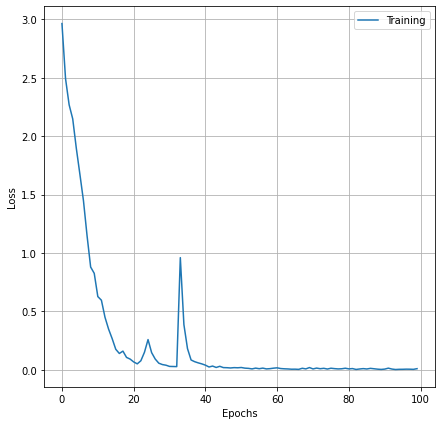

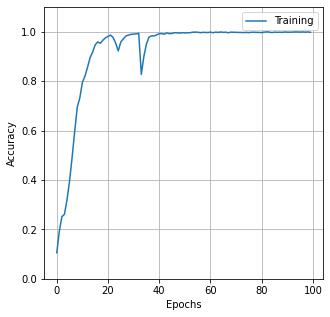

In [ ]:
plt.figure(figsize=(7,7)), plt.grid(), plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'] ,loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5)), plt.ylim(0,1.1) ,plt.grid(), plt.plot(history.history['acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

***
# Validation


In [21]:
# load best weights
model.load_weights("/content/drive/MyDrive/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [22]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [23]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [24]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       1.00      0.99      1.00      1000
           2       1.00      0.99      1.00       581
           3       1.00      1.00      1.00       166
           4       1.00      1.00      1.00       338
           5       0.97      1.00      0.99       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       0.88      1.00      0.93        14
           9       1.00      1.00      1.00       680
          10       1.00      0.99      1.00      1719
          11       1.00      0.99      1.00       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       0.99      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy                           1.00      7175
   macro avg       0.99   

***
# 恢复

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

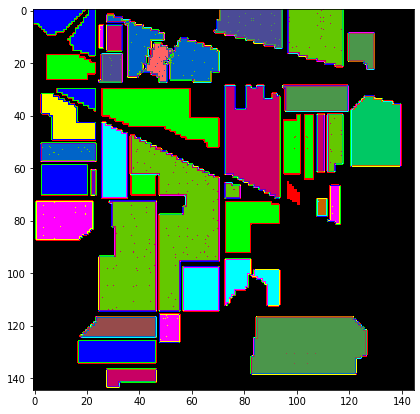

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))